# **Ohad Cohen & ActiveFence | Take‑Home Assignment: Feature Engineering for Text Classification**

### **Overview**

This notebook presents the submission for the Feature Engineering for Text Classification task. The chosen model is Logistic Regression. The model was trained on the provided dataset, which was split into training and test set. The training was performed using an NVIDIA A100 GPU. More details can be found in the report.

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

Load the CSV dataset:

In [4]:
df = pd.read_csv('/home/dsi/ohadico97/homework/ActiveFence/toxicity_toy_dataset.csv')

Emoji detection regex (using ChatGPT):

In [5]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & pictographs
    "\U0001F680-\U0001F6FF"  # Transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # Flags
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251"  # Enclosed characters
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U00002600-\U000026FF"  # Misc symbols
    "\U0001FA70-\U0001FAFF"  # Symbols & Pictographs Extended-A
    "]",
    flags=re.UNICODE,
)

### Generate Features from the Description Text Data

**Pre-processing the Raw Text**

Before I could create any features from the comments, I will have to clean the text. The common pre-processing steps are summarized below:

1. Removing punctuation - remove everything that is not in the form x,y,z. The first line of code below performs this task (keep only letters, digits, spaces).
2. Conversion to lowercase - words like 'PLEASE' and 'please' need to be considered as one word. Hence, these are converted to lowercase. The third line of code below performs this task.


In [6]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text)) # remove punctuation
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text).strip() # remove extra spaces
    return text

In [7]:
df['clean_comment'] = df['Comment'].apply(clean_text)
df['clean_comment']

0                    oh please you actually believe that
1                                     looool what a joke
2                         this again why do you even try
3                                wrong all caps no facts
4                                 who even asked you tho
                             ...                        
492    this showed real care for the conversation itself
493      appreciate your steady tone in a chaotic thread
494         you werent rushed or reactive thats powerful
495     that was a thoughtful pause in an intense moment
496    you turned a disagreement into a moment for gr...
Name: clean_comment, Length: 497, dtype: object

### Extract numeric features

**Numeric features:**

1. Comment length (characters and words).
2. Number of exclamation and question marks.
3. Proportion of uppercase letters.
4. Emoji count (using a Unicode regex).

In [8]:
def extract_numeric_features(original_texts, clean_texts):
    features = []
    for orig, clean in zip(original_texts, clean_texts):
        # length features
        char_len = len(clean)
        word_len = len(clean.split())
        # punctuation
        exclam = orig.count('!')
        question = orig.count('?')

        upper_ratio = sum(1 for c in orig if c.isupper()) / max(1, len(orig)) # compute the proportion of uppercase characters in the string orig

        # Swear count - didnt give any improvments
        # swear_count = predict([clean])[0] 
        # if swear_count >= 1: 
        #     print(clean)
        
        # Emoji count
        emoji_count = len(emoji_pattern.findall(str(orig)))
        
        features.append([char_len, word_len, exclam, question, upper_ratio, emoji_count])
    return np.array(features)

In [9]:
X_num = extract_numeric_features(df['Comment'], df['clean_comment'])
X_num.shape

(497, 6)

Scale numeric features:

In [11]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

**Extract also word and characters features:**

In [12]:
tfidf_word = TfidfVectorizer(ngram_range=(1,2),min_df=2) # Unigrams and bigrams
X_word = tfidf_word.fit_transform(df['clean_comment'])
X_word.shape

(497, 734)

Extract character n-grams (3 to 5 characters). This can capture misspellings and character-level patterns.

In [13]:
char_vect = CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=2) 
X_char = char_vect.fit_transform(df['clean_comment'])
X_char.shape

(497, 6759)

Combine all features:

In [14]:
X = hstack([X_word, X_char, X_num_scaled])
y = df['Toxic']
X.shape, y.shape

((497, 7499), (497,))

**Train-test split and model training:**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [18]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


**Evaluation:**

In [19]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Classification Report:
               precision    recall  f1-score   support

           0     0.9851    0.9429    0.9635        70
           1     0.8788    0.9667    0.9206        30

    accuracy                         0.9500       100
   macro avg     0.9319    0.9548    0.9421       100
weighted avg     0.9532    0.9500    0.9506       100



In [16]:
def confusion(ans,pred,acc,dic,model_name):
    cm = confusion_matrix(y_true=ans, y_pred=pred)
    cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    sns.heatmap(cmn*100, cmap='Blues', annot=True, fmt='.2f', xticklabels=dic.values(), yticklabels=dic.values())
    ax.xaxis.set_label_position("bottom")
    plt.setp(ax.get_yticklabels())
    plt.setp(ax.get_xticklabels())
    plt.title(model_name + " Accuracy: " + str(round(acc*100,1))+"%")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig("/home/dsi/ohadico97/homework/ActiveFence/"+model_name+"_cm_res.png",dpi=300)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: float or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure` or `~matplotlib.figure.SubFigure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 

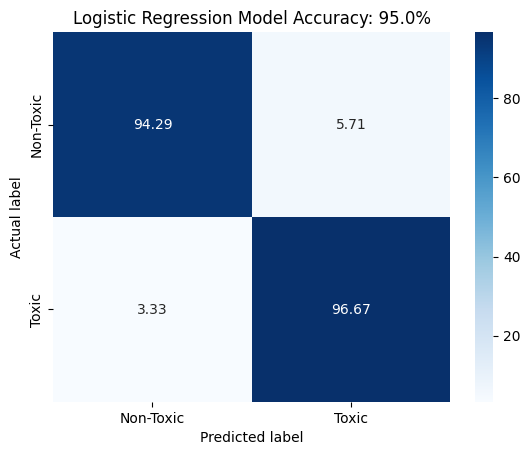

In [17]:
confusion(y_test, y_pred, accuracy_score(y_test, y_pred), {0: 'Non-Toxic', 1: 'Toxic'}, "Logistic Regression Model")

Cross-validation:

In [20]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("5-fold CV Accuracy scores:", cv_scores)
print("Average CV Accuracy score:", np.mean(cv_scores))

5-fold CV Accuracy scores: [0.96       0.99       0.92929293 0.94949495 0.96969697]
Average CV Accuracy score: 0.9596969696969697


Let's look at misclassified examples:

In [21]:
misclassified_indices = np.where(y_test != y_pred)[0]
print("Misclassified examples:")
for idx in misclassified_indices:
    print(f"True: {y_test.iloc[idx]}, Pred: {y_pred[idx]}")
    # Get the original index in the DataFrame for the test set
    original_idx = y_test.index[idx]
    print(f"Text: {df.loc[original_idx, 'Comment']}")
    print("---")

Misclassified examples:
True: 1, Pred: 0
Text: Hard disagree, respectfully not really
---
True: 0, Pred: 1
Text: Your restraint is admirable.
---
True: 0, Pred: 1
Text: Love the positive energy in this comment! 🌟
---
True: 0, Pred: 1
Text: So glad to read something this level-headed.
---
True: 0, Pred: 1
Text: You brought light, not heat.
---


### Feature Importance ###

In [ ]:
word_features = tfidf_word.get_feature_names_out()
char_features = char_vect.get_feature_names_out()
numeric_features = [
    "length_chars",
    "length_words",
    "exclam_count",
    "question_count",
    "uppercase_ratio",
    "emoji_count"
]

all_feature_names = list(word_features) + list(char_features) + numeric_features # must be in the same order as the features in X
assert X.shape[1] == len(all_feature_names), "Mismatch in number of features"
print("Total feature names:", len(all_feature_names))

# Top N features
N = 10

# get indices sorted by weight magnitude
coefs = model.coef_[0]
print("Total features in model:", len(coefs))
top_positive_indices = coefs.argsort()[::-1][:N] # get indices of top N features by positive coefficients
top_negative_indices = coefs.argsort()[:N] # get indices of top N features by negative coefficients

print("Top positive features (indicative of toxicity):")
for i in top_positive_indices:
    print(f"{all_feature_names[i]}: {coefs[i]:.4f}")

print("\nTop negative features (indicative of neutral):")
for i in top_negative_indices:
    print(f"{all_feature_names[i]}: {coefs[i]:.4f}")

Total feature names: 7499
Total features in model: 7499
Top positive features (indicative of toxicity):
question_count: 0.5630
uppercase_ratio: 0.4764
emoji_count: 0.3073
t t: 0.2835
st : 0.2772
 no: 0.2385
not: 0.2217
ot : 0.2031
take: 0.2005
ake: 0.1985

Top negative features (indicative of neutral):
length_chars: -1.3823
length_words: -0.7911
ed : -0.4553
and: -0.4149
ly : -0.3396
 re: -0.3305
 wa: -0.3066
tha: -0.2997
res: -0.2961
han: -0.2810


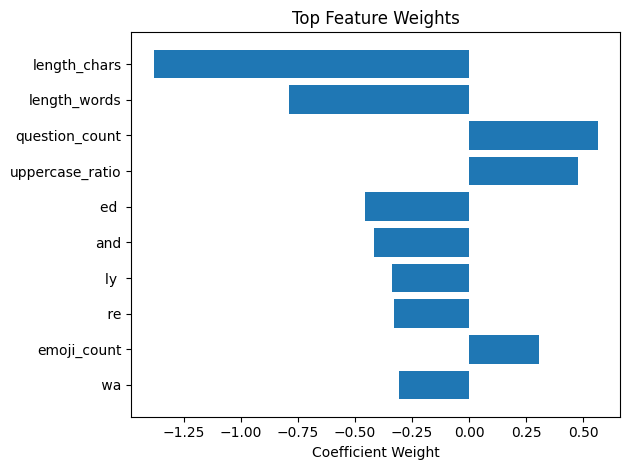

In [27]:
top_features = np.argsort(np.abs(coefs))[-N:] # Get indices of top N features by absolute value of coefficients
plt.barh([all_feature_names[i] for i in top_features],
    coefs[top_features]
)
plt.xlabel("Coefficient Weight")
plt.title("Top Feature Weights")
plt.tight_layout()
plt.savefig("/home/dsi/ohadico97/homework/ActiveFence/"+str(N)+"_feature_importance2.png",dpi=300)
plt.show()